In [207]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise
import matplotlib.pyplot as plt
from pandas.plotting import parallel_coordinates
import seaborn as sns

In [208]:
file = pd.read_csv("AnalysisOut.csv")
file

,Code,State Code,County Code,County Name/State Abbreviation,Year,Labor Force,Employed,Unemployed,Unemployment Rate (%),State,Unemployed Rate Category
0,CN0100100000000,1.0,1.0,"Autauga County, AL",2015.0,25541.0,24206.0,1335.0,5.2,AL,Medium
1,CN0100300000000,1.0,3.0,"Baldwin County, AL",2015.0,87493.0,82619.0,4874.0,5.6,AL,Medium
2,CN0100500000000,1.0,5.0,"Barbour County, AL",2015.0,8590.0,7823.0,767.0,8.9,AL,High
3,CN0100700000000,1.0,7.0,"Bibb County, AL",2015.0,8552.0,7983.0,569.0,6.7,AL,Medium
4,CN0100900000000,1.0,9.0,"Blount County, AL",2015.0,24416.0,23089.0,1327.0,5.4,AL,Medium
...,...,...,...,...,...,...,...,...,...,...,...
28259,CN5603700000000,56.0,37.0,"Sweetwater County, WY",2023.0,20251.0,19575.0,676.0,3.3,WY,Low
28260,CN5603900000000,56.0,39.0,"Teton County, WY",2023.0,17327.0,16955.0,372.0,2.1,WY,Low
28261,CN5604100000000,56.0,41.0,"Uinta County, WY",2023.0,9096.0,8807.0,289.0,3.2,WY,Low
28262,CN5604300000000,56.0,43.0,"Washakie County, WY",2023.0,3843.0,3716.0,127.0,3.3,WY,Low


filter only CA and CA counties

In [209]:
Calcounties = file[file['State'] == 'CA']
Calcounties23 = Calcounties[Calcounties['Year'] == 2023]
Calcounties23.head()

,Code,State Code,County Code,County Name/State Abbreviation,Year,Labor Force,Employed,Unemployed,Unemployment Rate (%),State,Unemployed Rate Category
25310,CN0600100000000,6.0,1.0,"Alameda County, CA",2023.0,826102.0,792439.0,33663.0,4.1,CA,Low
25311,CN0600300000000,6.0,3.0,"Alpine County, CA",2023.0,540.0,505.0,35.0,6.5,CA,Medium
25312,CN0600500000000,6.0,5.0,"Amador County, CA",2023.0,14404.0,13673.0,731.0,5.1,CA,Medium
25313,CN0600700000000,6.0,7.0,"Butte County, CA",2023.0,91910.0,87088.0,4822.0,5.2,CA,Medium
25314,CN0600900000000,6.0,9.0,"Calaveras County, CA",2023.0,21956.0,21030.0,926.0,4.2,CA,Low


In [210]:
#compute the average of duplicate counties in California


Selecting relevant features

In [211]:
Calcounties23 = Calcounties23.drop(columns=['State', 'Code', 'State Code', 'County Code', 'Year', 'Unemployed Rate Category', 'Unemployment Rate (%)'])
Calcounties23.head()

,County Name/State Abbreviation,Labor Force,Employed,Unemployed
25310,"Alameda County, CA",826102.0,792439.0,33663.0
25311,"Alpine County, CA",540.0,505.0,35.0
25312,"Amador County, CA",14404.0,13673.0,731.0
25313,"Butte County, CA",91910.0,87088.0,4822.0
25314,"Calaveras County, CA",21956.0,21030.0,926.0


In [212]:
Calcounties23 = Calcounties23.set_index('County Name/State Abbreviation')
Calcounties23.head()

,Labor Force,Employed,Unemployed
County Name/State Abbreviation,,,
"Alameda County, CA",826102.0,792439.0,33663.0
"Alpine County, CA",540.0,505.0,35.0
"Amador County, CA",14404.0,13673.0,731.0
"Butte County, CA",91910.0,87088.0,4822.0
"Calaveras County, CA",21956.0,21030.0,926.0


Since the numbers are scale, we do not need to apply normalization

In [213]:
#compute Euclidean distance for each pair of counties
Eudist = pairwise.pairwise_distances(Calcounties23, metric='euclidean')

dist = pd.DataFrame(Eudist, columns=Calcounties23.index, index=Calcounties23.index)

Optimize the number of clusters

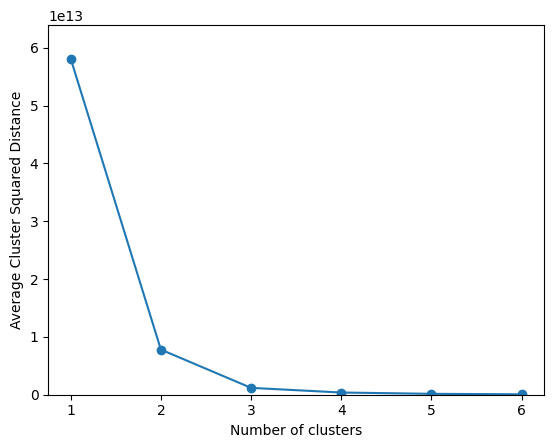

In [214]:
fig, ax = plt.subplots(facecolor='white')
inertia = []

for n_clusters in range(1,7):
    kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(Calcounties23)
    inertia.append(kmeans.inertia_/n_clusters)

inertias = pd.DataFrame({'n_clusters':range(1,7), 'inertia': inertia})
ax = inertias.plot(x='n_clusters', y='inertia', marker='o', ax=ax)
plt.xlabel('Number of clusters')
plt.ylabel('Average Cluster Squared Distance')
plt.ylim((0, 1.1*inertias.inertia.max()))
ax.legend().set_visible(False)
plt.show()


As observed from the graph, the best number of cluster (depending on interpretation) would either be 2 or 3 due to steep slope. Number of cluster does not differ significantly in distance after 3. 

In [215]:
#apply k-means clustering
kmeans = KMeans(n_clusters=3, random_state=0).fit(Calcounties23)

#cluster membership
memb = pd.Series(kmeans.labels_, index=Calcounties23.index)
print(memb)

County Name/State Abbreviation
Alameda County, CA               2
Alpine County, CA                0
Amador County, CA                0
Butte County, CA                 0
Calaveras County, CA             0
Colusa County, CA                0
Contra Costa County, CA          0
Del Norte County, CA             0
El Dorado County, CA             0
Fresno County, CA                0
Glenn County, CA                 0
Humboldt County, CA              0
Imperial County, CA              0
Inyo County, CA                  0
Kern County, CA                  0
Kings County, CA                 0
Lake County, CA                  0
Lassen County, CA                0
Los Angeles County, CA           1
Madera County, CA                0
Marin County, CA                 0
Mariposa County, CA              0
Mendocino County, CA             0
Merced County, CA                0
Modoc County, CA                 0
Mono County, CA                  0
Monterey County, CA              0
Napa County, CA         

In [216]:
#clustering results for 2023
print('Clustering results for Year 2023')
for key, item in memb.groupby(memb):
    print(key, ': ', ', '.join(item.index))

Clustering results for Year 2023
0 :  Alpine County, CA, Amador County, CA, Butte County, CA, Calaveras County, CA, Colusa County, CA, Contra Costa County, CA, Del Norte County, CA, El Dorado County, CA, Fresno County, CA, Glenn County, CA, Humboldt County, CA, Imperial County, CA, Inyo County, CA, Kern County, CA, Kings County, CA, Lake County, CA, Lassen County, CA, Madera County, CA, Marin County, CA, Mariposa County, CA, Mendocino County, CA, Merced County, CA, Modoc County, CA, Mono County, CA, Monterey County, CA, Napa County, CA, Nevada County, CA, Placer County, CA, Plumas County, CA, San Benito County, CA, San Francisco County/city, CA, San Joaquin County, CA, San Luis Obispo County, CA, San Mateo County, CA, Santa Barbara County, CA, Santa Cruz County, CA, Shasta County, CA, Sierra County, CA, Siskiyou County, CA, Solano County, CA, Sonoma County, CA, Stanislaus County, CA, Sutter County, CA, Tehama County, CA, Trinity County, CA, Tulare County, CA, Tuolumne County, CA, Ventu

Visualize the clustering

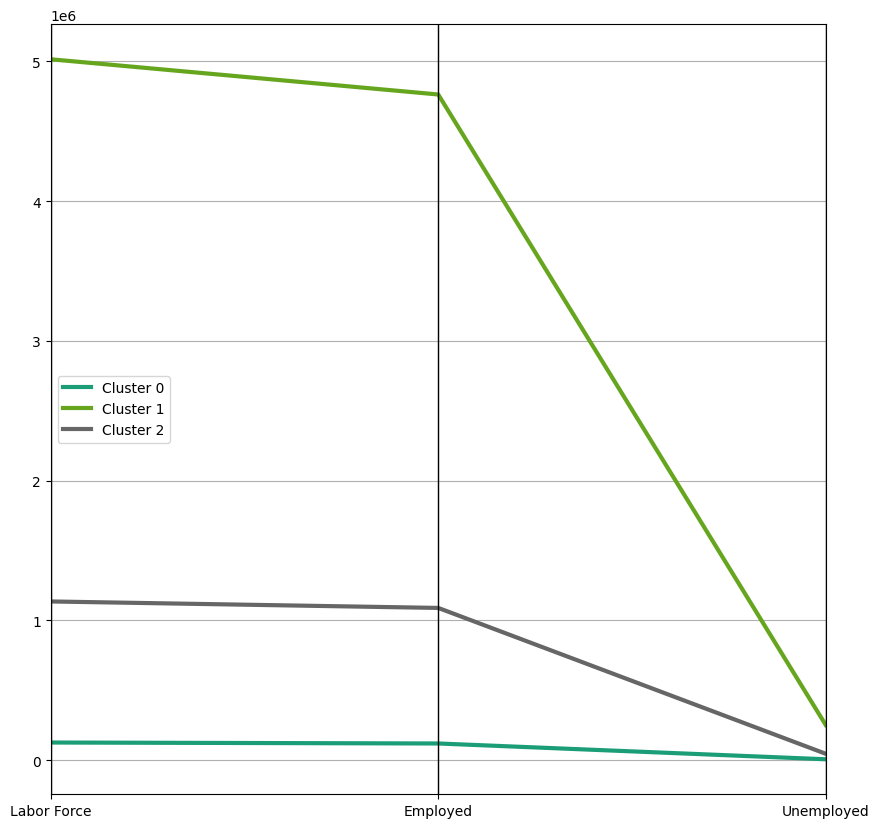

In [217]:
centroids = pd.DataFrame(kmeans.cluster_centers_, columns=Calcounties23.columns)

centroids['cluster'] = ['Cluster {}'.format(i) for i in centroids.index]
fig = plt.figure(figsize=(10,10), facecolor='white')


ax = parallel_coordinates(centroids, class_column='cluster', colormap='Dark2', linewidth=3)
plt.legend(loc='center left',)
